<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up ( 🍔👀 Food Vision mini)

We've seen the power of the transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks. Let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-05-26 17:23:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-26 17:23:59 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
our goal is to beat the original Food101 paper with 10% of the training data.

We are using data from Food101 dataset and preprocesed data using [image_data_modification](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/image_data_modification.ipynb) code.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-05-26 17:24:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   161MB/s    in 10s     

2025-05-26 17:24:21 (148 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_pe

In [6]:
# Setup data inputs (or make a image into a tensor or numbers)
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validat on 15% of the test data, to save epoch time)

In [7]:
# Create a ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers, Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1./255)
], name="data_augmentation")

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs, training=True) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay  frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate only 15% of test data
                                           callbacks=[checkpoint_callback])


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.1611 - loss: 3.9612 - val_accuracy: 0.4142 - val_loss: 2.5937
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 863s 4s/step - accuracy: 0.4756 - loss: 2.3415 - val_accuracy: 0.4772 - val_loss: 2.1401
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 924s 4s/step - accuracy: 0.5547 - loss: 1.9002 - val_accuracy: 0.5241 - val_loss: 1.9101
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - accuracy: 0.5793 - loss: 1.7025 - val_accuracy: 0.5291 - val_loss: 1.8282
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 856s 3s/step - accuracy: 0.6227 - loss: 1.5351 - val_accuracy: 0.5294 - val_loss: 1.7941


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1781s 2s/step - accuracy: 0.5601 - loss: 1.6775


[1.5813847780227661, 0.584673285484314]

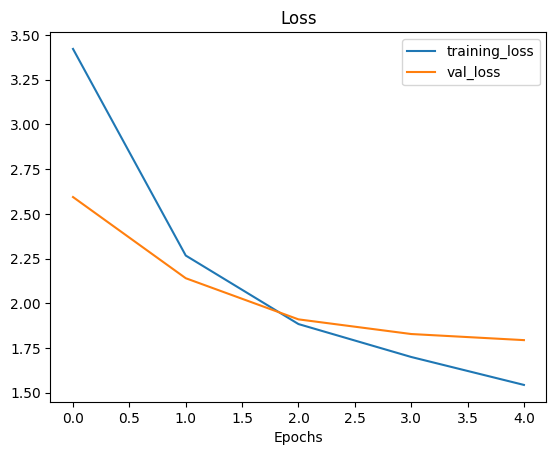

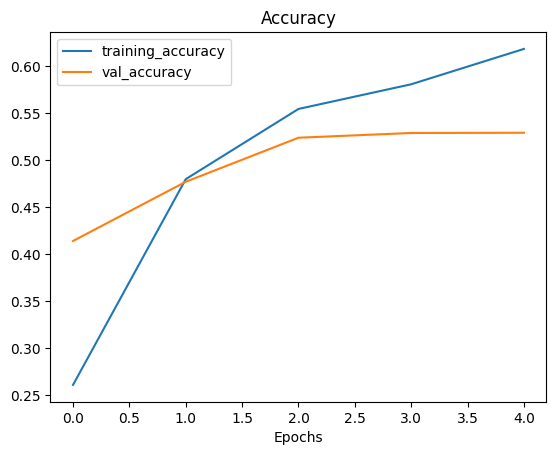

In [15]:
plot_loss_curves(history_all_classes_10_percent)

> ✍ **Observation:** Ideally, the two curves should be very similar to each other. If not, it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data). So it seems, our model may be overfitting a little bit. We will try to reduce the overfitting in further experiment of this notebook.

## Fine-tuning

In [16]:
# Unfreeze last 5 layers in the base model
base_model.trainable = False

for layer in base_model.layers[-5:]:
  layer.trainable = True

In [17]:
# Recompile model with lower learning rate: it's typically best practice to lower the learning rate when fine-tuning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10  # it is the total epochs = feature extraction epochs 5 + 5 fine tune epochs

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 890s 4s/step - accuracy: 0.6358 - loss: 1.4901 - val_accuracy: 0.5540 - val_loss: 1.6997
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 921s 4s/step - accuracy: 0.6700 - loss: 1.3166 - val_accuracy: 0.5715 - val_loss: 1.6387
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 918s 4s/step - accuracy: 0.6899 - loss: 1.2443 - val_accuracy: 0.5728 - val_loss: 1.6256
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.7123 - loss: 1.1532 - val_accuracy: 0.5699 - val_loss: 1.6221
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.7297 - loss: 1.1158 - val_accuracy: 0.5842 - val_loss: 1.5783
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 867s 4s/step - accuracy: 0.7411 - loss: 1.0585 - val_accuracy: 0.5861 - val_loss: 1.5699


In [21]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1748s 2s/step - accuracy: 0.5995 - loss: 1.4997


[1.4104543924331665, 0.6203960180282593]

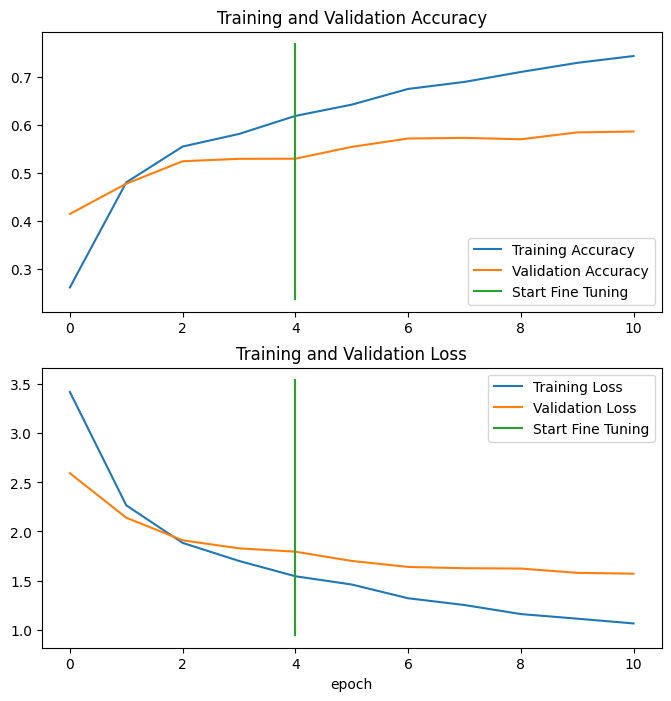

In [22]:
# Compare the histories of feature extraction model with fine-tunining model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use it in an external application, we'll need to save it and export it somewhere.

In [25]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Colab_Notebooks/101_food_classes_10_percent_saved_big_dog_model.keras")

In [26]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/101_food_classes_10_percent_saved_big_dog_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1825s 2s/step - accuracy: 0.5995 - loss: 1.4997


[1.4104543924331665, 0.6203960180282593]

In [28]:
# The results from our loaded model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4104543924331665, 0.6203960180282593]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [29]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2025-05-27 00:09:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   126MB/s    in 0.4s    

2025-05-27 00:09:07 (126 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [34]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

In [47]:
model = tf.keras.layers.TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint="serving_default")

In [50]:
# Using this because the model didn't saved as .keras or .h5
# loaded_saved_model = tf.keras.models.load_model("/content/101_food_classes_10_percent_saved_big_dog_model")

# from keras.layers import TFSMLayer
# from keras import Sequential

# # Load TensorFlow SavedModel using TFSMLayer for inference
# model = Sequential([
#     TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint="serving_default")
# ])

In [49]:
# Check to see if loaded model is a trained model

# loaded_loss, loaded_accuracy = model.evaluate(test_data)
# loaded_loss, loaded_accuracy